<h1>Brain Tumor Detection Demo</h1>

Install neccesary libraries

In [1]:
!pip install seaborn
!pip install pyyaml h5py

Import neccesary libraries

In [2]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
import tensorflow as tf
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-07-11 19:14:18.297687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 19:14:18.297731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 19:14:18.297740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 19:14:18.304454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Prelim Code</h3>

In [3]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [4]:
# Set the path to the dataset
# Define the training and testing directories
train_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Training"
test_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Testing"

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

#Set GPU as main computational method

tf.config.list_physical_devices('GPU')

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


<h2>Dataset Distribution</h2>

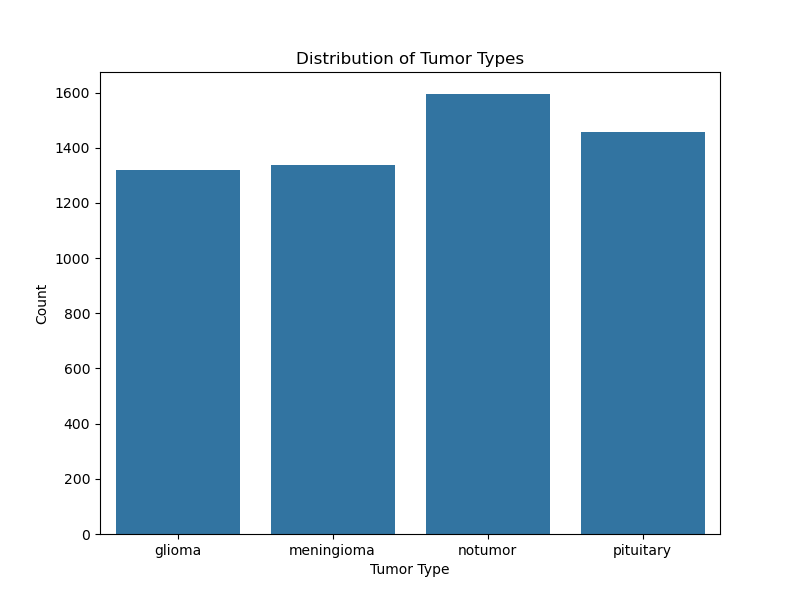

In [5]:
display.Image("/home/sagemaker-user/BrainTumorDetectionML/plots/dataDistribution.png")

<h2>Example Image of Each Tumor</h2>

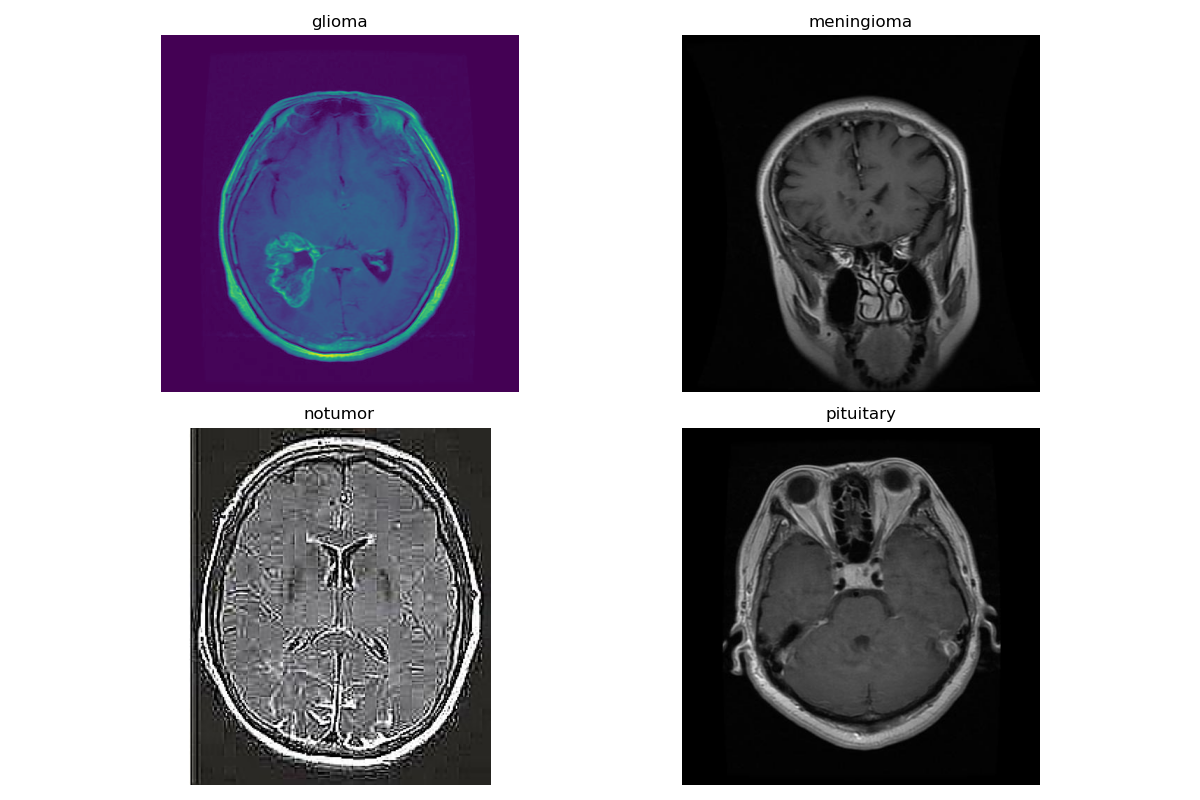

In [6]:
display.Image("/home/sagemaker-user/BrainTumorDetectionML/plots/exampleTumors.png")

<hr>
<h2>Image Preproccessing - Explained</h2>

<h2>Model Architecture & Design (Explained in main.ipynb)</h2>

Load model:

In [7]:
history = tf.keras.models.load_model('/home/sagemaker-user/BrainTumorDetectionML/savedModels/tumorML.keras')

In [8]:
history.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

<hr>
<h2>Accuracy</h2>

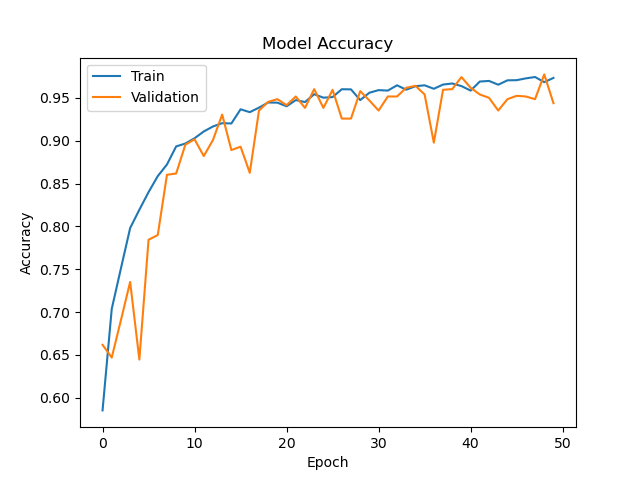

In [9]:
display.Image("/home/sagemaker-user/BrainTumorDetectionML/plots/Model_Accuracy.png")

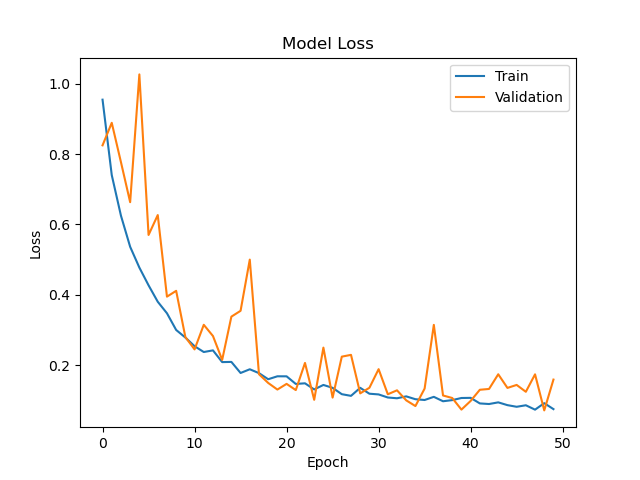

In [10]:
display.Image("/home/sagemaker-user/BrainTumorDetectionML/plots/Model_Loss.png")

<br>
<h2>Machine Learning Predictions Explained</h2>

<h3>Confusion Matrix</h3>

41/41 [==============================] - 4s 96ms/step


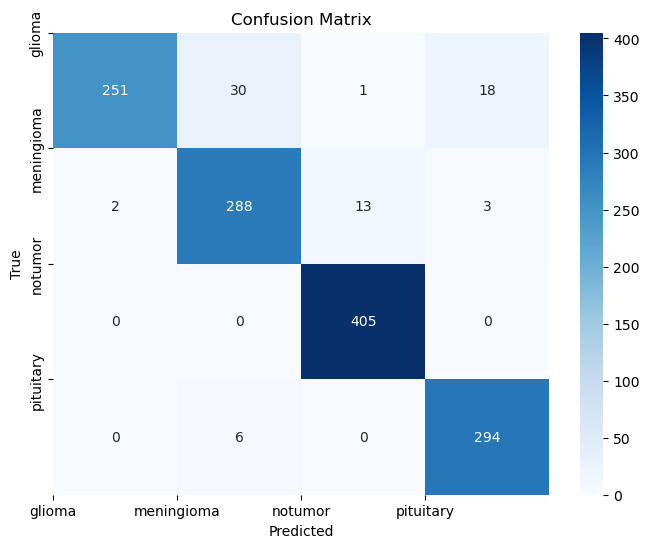

In [11]:
# Make predictions on the test dataset
predictions = history.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

<h3>Predicting Images</h3>

Class: glioma
Precision: 0.9920948616600791
Recall: 0.8366666666666667
F1-Score: 0.9077757685352622

Class: meningioma
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1-Score: 0.9142857142857143

Class: notumor
Precision: 0.9665871121718377
Recall: 1.0
F1-Score: 0.9830097087378641

Class: pituitary
Precision: 0.9333333333333333
Recall: 0.98
F1-Score: 0.9560975609756097



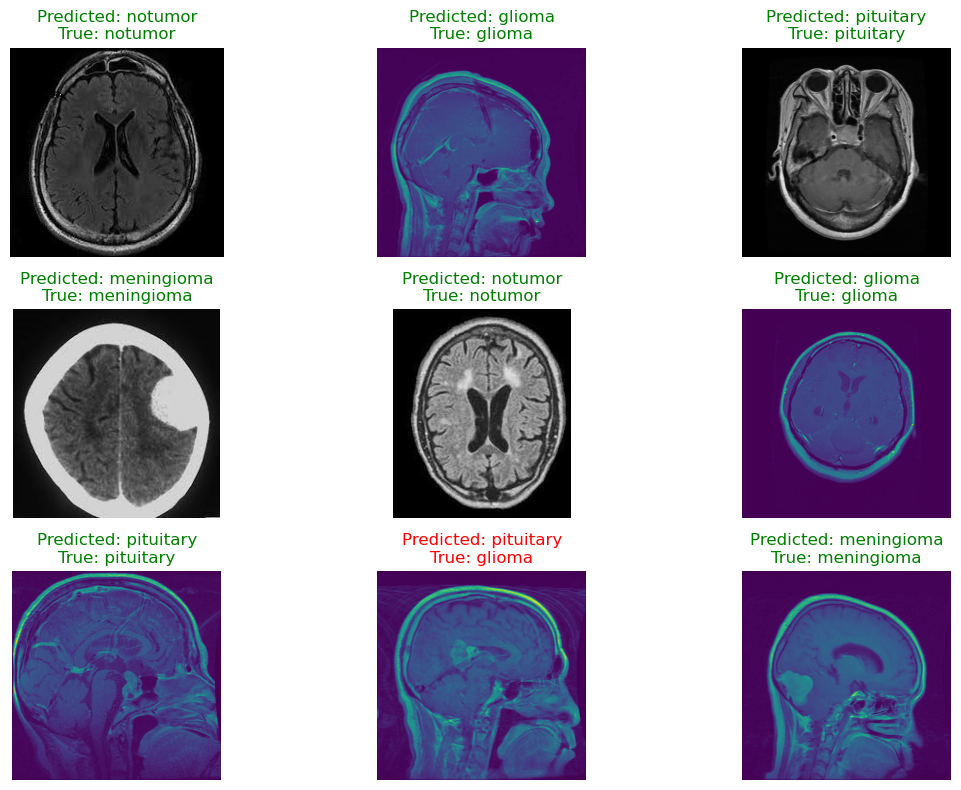

In [13]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()